# EE634 Intro to Neural Networks
# Assignment #5: MobileNet-v2
# Zachary Chou
## Fall 2023

In [1]:
# Import libraries 
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import ParameterSampler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

import datetime
import os
import matplotlib.pyplot as plt

# Downloading Building the Model

In [2]:
# Avoid kernel crash
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
# Load the pre-trained MobileNetV2 model, excluding the top classification layer
base_model = MobileNetV2(input_shape=(96, 96, 3), include_top=False, weights='imagenet')

# Freeze the base model
base_model.trainable = False

In [4]:
# Create new model on top
inputs = Input(shape=(96, 96, 3))
x = base_model(inputs)
x = GlobalAveragePooling2D()(x)
outputs = Dense(10, activation='softmax')(x)
model = Model(inputs, outputs)

# Downloading and Processing the Data

In [5]:
# Load CIFAR-10 data
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [6]:
# Checking the images dimensions
display(train_images.shape)
display(test_images.shape)

(50000, 32, 32, 3)

(10000, 32, 32, 3)

In [7]:
# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

In [8]:
# Convert labels to one-hot encoding
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

In [9]:
# Resize images from 32x32 to 96x96 to fit MobileNetV2 input size requirements
train_images_resized = tf.image.resize(train_images, (96, 96))
test_images_resized = tf.image.resize(test_images, (96, 96))

# Compiling and Training the Model

In [26]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
# Train the model
history = model.fit(
    train_images_resized, train_labels,
    epochs=5,
    batch_size = 128,
    validation_split=0.3,
)

Epoch 1/5
274/274 [==============================] - 92s 336ms/step - loss: 0.4972 - accuracy: 0.8259 - val_loss: 0.5713 - val_accuracy: 0.7999
Epoch 2/5
274/274 [==============================] - 96s 351ms/step - loss: 0.4839 - accuracy: 0.8319 - val_loss: 0.5802 - val_accuracy: 0.7973
Epoch 3/5
274/274 [==============================] - 98s 357ms/step - loss: 0.4715 - accuracy: 0.8356 - val_loss: 0.5960 - val_accuracy: 0.7936
Epoch 4/5
274/274 [==============================] - 89s 327ms/step - loss: 0.4635 - accuracy: 0.8391 - val_loss: 0.5806 - val_accuracy: 0.7987
Epoch 5/5
274/274 [==============================] - 95s 346ms/step - loss: 0.4547 - accuracy: 0.8422 - val_loss: 0.5850 - val_accuracy: 0.7972


In [31]:
# Evaluate the model
model.evaluate(test_images_resized, test_labels)

313/313 [==============================] - 27s 87ms/step - loss: 0.5838 - accuracy: 0.8000


[0.5837627649307251, 0.800000011920929]

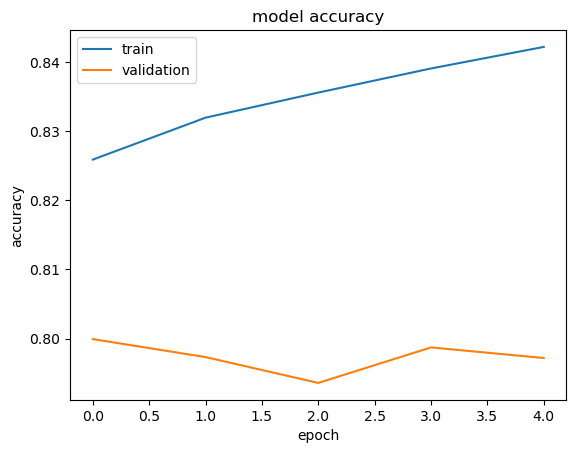

In [32]:
# Model accuracy as a plot for the train and test
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

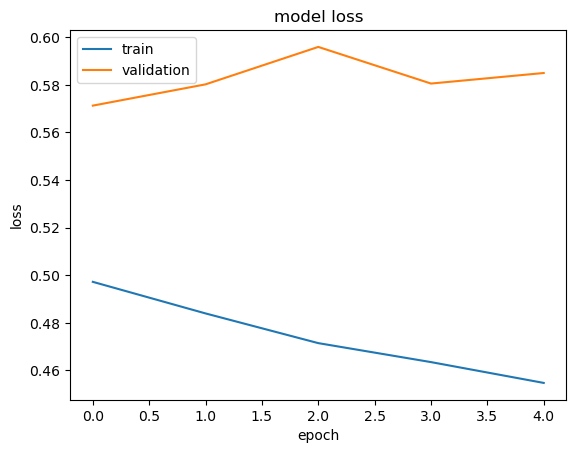

In [33]:
# Model loss over epochs as a plot for the train and test
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# Accuracy 
# Training: 84%
# Validation: 80% 
# Testing: 58% 

# Optimizing the model with Grid Search 

In [56]:
# Running the two hyperparameters in a grid search for batch size and learning rate 
# The tensorboard is then shown by going to the anaconda cmd and 
# typing tensorboard --logdir logs 
# In a web browser, type http://localhost:6006
param_grid = {'learning_rate': [0.1, 0.01, 0.001], 'batch_size': [32, 64, 128]}

grid = ParameterGrid(param_grid)

for params in grid:
    learning_rate = params['learning_rate']
    batch_size = params['batch_size']

    base_model = MobileNetV2(input_shape=(96, 96, 3), include_top=False, weights='imagenet')
    base_model.trainable = False

    inputs = Input(shape=(96, 96, 3))
    x = base_model(inputs)
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(10, activation='softmax')(x)
    model = Model(inputs, outputs)

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    log_dir = os.path.join(
        "logs",
        "learning_rate_" + str(learning_rate) + "_batch_size_" + str(batch_size),
        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),
    )
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

    model.fit(
        train_images_resized, train_labels,
        epochs=5,
        batch_size=batch_size,
        validation_split=0.3,
        callbacks=[tensorboard_callback],
    )

Epoch 1/5
1094/1094 [==============================] - 178s 155ms/step - loss: 11.6202 - accuracy: 0.6890 - val_loss: 13.0405 - val_accuracy: 0.7146
Epoch 2/5
1094/1094 [==============================] - 167s 153ms/step - loss: 13.1541 - accuracy: 0.7347 - val_loss: 18.5609 - val_accuracy: 0.7099
Epoch 3/5
1094/1094 [==============================] - 164s 150ms/step - loss: 12.4402 - accuracy: 0.7611 - val_loss: 15.9436 - val_accuracy: 0.7265
Epoch 4/5
1094/1094 [==============================] - 164s 150ms/step - loss: 12.3614 - accuracy: 0.7677 - val_loss: 16.9829 - val_accuracy: 0.7274
Epoch 5/5
1094/1094 [==============================] - 167s 153ms/step - loss: 12.7100 - accuracy: 0.7730 - val_loss: 17.8034 - val_accuracy: 0.7377
Epoch 1/5
1094/1094 [==============================] - 178s 157ms/step - loss: 1.3796 - accuracy: 0.7072 - val_loss: 1.6341 - val_accuracy: 0.7095
Epoch 2/5
1094/1094 [==============================] - 166s 151ms/step - loss: 1.2862 - accuracy: 0.7554 - v

In [57]:
# Analysis 
# Based on the tensor board, the learning rate shows the time it takes 
# for the training to be done with the higher the learning rate 
# the faster the training. For the batch size, the larger the 
# size, the faster computation but less generalization
# or not being able to paint the whole picture of the training data
# the tensor board helps with visually representing the 
# data as shown above with graphs to show 
# which combination of the learning rate and batch size is the 
# best of both worlds 

# Optimizing the model with random search

In [11]:
# Doing random search with learning rate, neurons in dense layers, 
# and activation functions
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'neurons': [64, 128, 256],
    'activation': ['relu', 'elu', 'selu']
}

n_iter_search = 8
random_search = ParameterSampler(param_grid, n_iter=n_iter_search)

for params in random_search:
    
    learning_rate = params['learning_rate']
    neurons = params['neurons']
    activation = params['activation']

    
    base_model = MobileNetV2(input_shape=(96, 96, 3), include_top=False, weights='imagenet')
    base_model.trainable = False

    inputs = Input(shape=(96, 96, 3))
    x = base_model(inputs)
    x = GlobalAveragePooling2D()(x)
    x = Dense(neurons, activation=activation)(x)
    outputs = Dense(10, activation='softmax')(x)
    model = Model(inputs, outputs)

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    log_dir = os.path.join(
        "logs",
        "learning_rate_" + str(learning_rate) + "_neurons_" + str(neurons) + "_activation_" + activation,
        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),
    )
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

    model.fit(
        train_images_resized, train_labels,
        epochs=5,
        batch_size=128,
        validation_split=0.3,
        callbacks=[tensorboard_callback],
    )

Epoch 1/5
274/274 [==============================] - 407s 1s/step - loss: 1.0147 - accuracy: 0.7021 - val_loss: 0.6705 - val_accuracy: 0.7620
Epoch 2/5
274/274 [==============================] - ETA: 0s - loss: 0.6329 - accuracy: 0.7794

KeyboardInterrupt: 

## DUE DATE: Friday, December 8th, 2023